##### Import the Libraries

In [24]:
import cv2
import numpy as np
import time
import keyboard
import pytesseract
from mss import mss
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure

import matplotlib.pyplot as plt
import os

In [25]:
# Create directories if they don't exist
os.makedirs('./dqn/models', exist_ok=True)
os.makedirs('./dqn/logs', exist_ok=True)
os.makedirs('./dqn/tensorboard', exist_ok=True)

### Create an environment

In [30]:
class ChromeDinoEnv(Env):
    def __init__(self):
        super(ChromeDinoEnv, self).__init__()
        
        # Define action space: 0 = do nothing, 1 = jump, 2 = duck
        self.action_space = Discrete(3)
        
        # Define observation space to match _get_observation output
        self.observation_space = Box(low=0, high=255, shape=(83, 100, 1), dtype=np.uint8)
        
        # Screen capture setup
        self.sct = mss()
        self.game_location = {'top': 110, 'left': 50, 'width': 600, 'height': 500}
        self.done_location = {'top': 200, 'left': 600, 'width': 600, 'height': 70}
        
        # Initialize game state
        self.game_over = False
        self.step_count = 0

    def reset(self, **kwargs):
        # Reset the game
        keyboard.press_and_release('space')
        time.sleep(1)
        
        self.game_over = False
        self.step_count = 0
        return self._get_observation(), {}

    def step(self, action):
        # Perform action
        if action == 1:
            keyboard.press_and_release('up')
        elif action == 2:
            keyboard.press_and_release('down')
        
        time.sleep(0.1)
        
        observation = self._get_observation()
        self.game_over, _ = self._check_game_over()
        self.step_count += 1
        
        # Define reward and termination conditions
        reward = 1 if not self.game_over else -10
        done = self.game_over  
        
        return observation, reward, done, False, {}

    # def _get_observation(self):
    #     raw = np.array(self.sct.grab(self.game_location))[:,:,:3].astype(np.uint8)
    #     gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
    #     resized = cv2.resize(gray, (100, 83))
    #     channel = np.reshape(resized, (1, 83, 100))
    #     return channel

    def _get_observation(self):
        raw = np.array(self.sct.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100, 83))
        # Return with channels last (height, width, channels)
        return np.expand_dims(resized, axis=-1)
    
    def _check_game_over(self):
        done_cap = np.array(self.sct.grab(self.done_location))
        text = pytesseract.image_to_string(done_cap).lower()
        done = "game over" in text
        return done, done_cap

    def render(self, mode='human'):
        observation = self._get_observation().squeeze()
        observation = (observation * 255).astype(np.uint8)
        cv2.imshow('Game', observation)
        cv2.waitKey(1)

    def close(self):
        cv2.destroyAllWindows()

#### Train the Model

In [31]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True
    
CHECKPOINT_DIR = './dqn/train/'
LOG_DIR = './dqn/logs/'
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [32]:

# Create and wrap the environment
time.sleep(5)  # Give time to focus the game window
env = ChromeDinoEnv()
# Initialize DQN model with more reasonable parameters
# model = DQN(
#     'CnnPolicy',
#     env,
#     verbose=1,
#     tensorboard_log='./dqn/tensorboard/',
#     buffer_size=100000,  # Reduced from 1.2M to avoid memory warning
#     learning_starts=1000,
#     batch_size=32,
#     learning_rate=1e-4,
#     gamma=0.99,
#     target_update_interval=1000,
#     exploration_fraction=0.1,
#     exploration_final_eps=0.01,
#     train_freq=4
# )
new_logger = configure(LOG_DIR, ["stdout", "csv", "tensorboard"])
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=1000)
model.set_logger(new_logger)

# Train the model
# model.learn(
#     total_timesteps=100000,
#     callback=[checkpoint_callback, eval_callback],
#     progress_bar=True
# )
model.learn(total_timesteps=100000, callback=callback)

# Save the final model
# model.save('./dqn/models/final_dino_model')

# Close the environment
# env.close()

Logging to ./dqn/logs/
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/Users/alexkagozi/Desktop/AI/ReinforcemnentLearning/chrome-dinosaur/.venv/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 1.56GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.8     |
|    ep_rew_mean      | 2.75     |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 19       |
|    total_timesteps  | 55       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.8     |
|    ep_rew_mean      | 0.75     |
|    exploration_rate | 0.991    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 33       |
|    total_timesteps  | 94       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.8     |
|    ep_rew_mean      | 1.75     |
|    exploration_rate | 0.985    |
| time/               |          |
|    episodes       

KeyboardInterrupt: 

### Load and Test the Model

In [50]:
# Load the model
time.sleep(5)  # Give time to focus the game window
env = ChromeDinoEnv()
model = DQN.load('./dqn/train/best_model_90000', env=env)

for episode in range(5): 
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info, _ = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode + 1, total_reward))
    time.sleep(2)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/Users/alexkagozi/Desktop/AI/ReinforcemnentLearning/chrome-dinosaur/.venv/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 1.68GB
  warnings.warn(


Total Reward for episode 1 is 32
Total Reward for episode 2 is 66
Total Reward for episode 3 is 21
Total Reward for episode 4 is 9
Total Reward for episode 5 is 6


#### Display Metrics

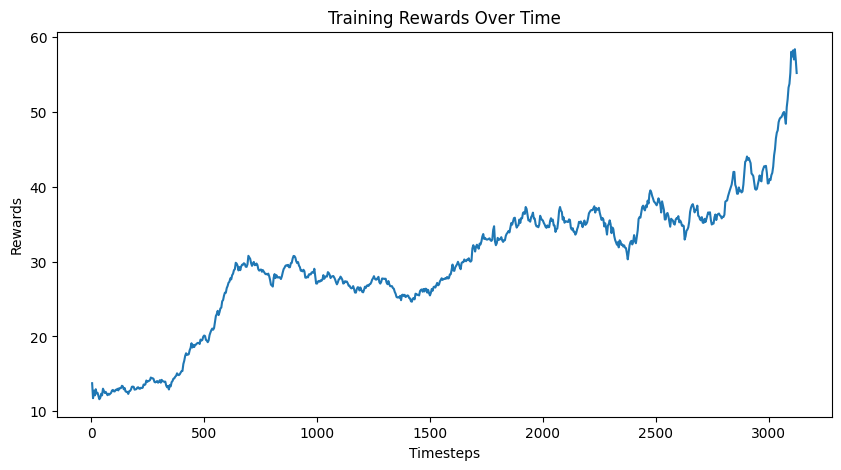

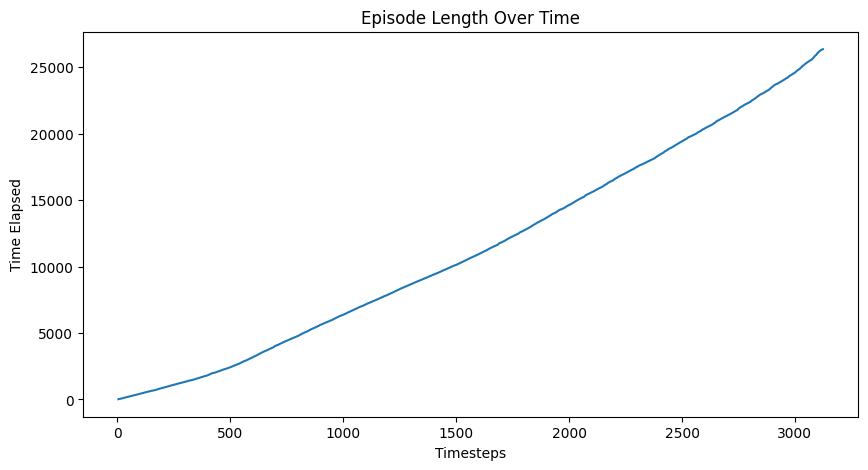

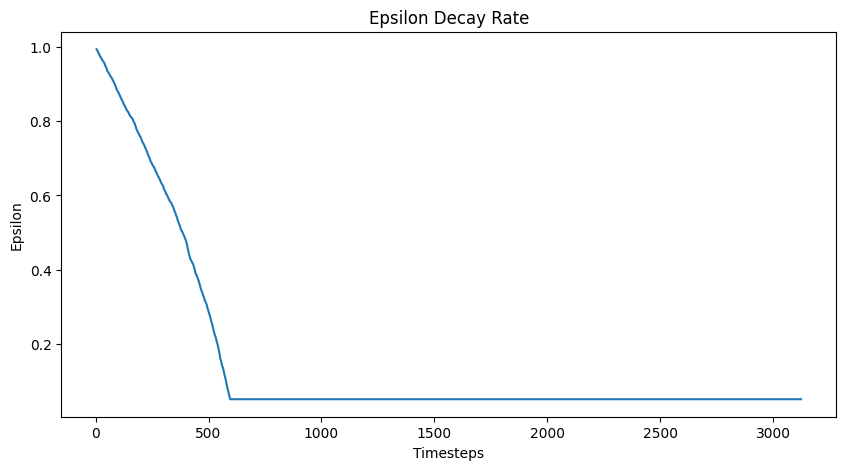

In [52]:
import pandas as pd

# Load the logs
logs = pd.read_csv('./dqn/logs/progress.csv')
# logs = logs[['time/episodes', 'rollout/ep_len_mean']]
# Plot the two columns
# Plot the rewards
plt.figure(figsize=(10, 5))
plt.plot(logs['time/episodes'], logs['rollout/ep_len_mean'])
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.title('Training Rewards Over Time')
plt.show()

# Plot the episode lengths
plt.figure(figsize=(10, 5))
plt.plot(logs['time/episodes'], logs['time/time_elapsed'])
plt.xlabel('Timesteps')
plt.ylabel('Time Elapsed')
plt.title('Episode Length Over Time')
plt.show()

# Plot the epsilon values
plt.figure(figsize=(10, 5))
plt.plot(logs['time/episodes'], logs['rollout/exploration_rate'])
plt.xlabel('Timesteps')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay Rate')
plt.show()